# Direct Query Question Analysis

The 8 `adl-benchmark` questions were listed [here](README.md). The details of the models used to run over them can be found [here](models.yaml). This notebook is an analysis of the results.

The following was the *process* used:

1. Each question and model is done in isolation - nothing is learned or retained from one question to the next.
1. A prompt is assembled with the following contents:
    - [Some prompt text](https://github.com/gordonwatts/atlas-plot-agent/blob/d3a8363630234f16dc3248a092d5ff92d4c57b58/notebooks/adl-benchmarks/direct-query-config.yaml#L8)
    - [Hint files](https://github.com/gordonwatts/hep-programming-hints/tree/1.0.0)
    - The question (the question is sourced from the [README.md](README.md) file)
1. The LLM returns with some text and python code.
1. The python code is run in a docker container
1. If `png` files are produced as output, then the question is considered successfully answered (see the below section on hallucinations), and we move onto the next question.
1. If not, then a new prompt is assembled:
    - [Different prompt text](https://github.com/gordonwatts/atlas-plot-agent/blob/d3a8363630234f16dc3248a092d5ff92d4c57b58/notebooks/adl-benchmarks/direct-query-config.yaml#L30)
    - [Hint files](https://github.com/gordonwatts/hep-programming-hints/tree/1.0.0)
    - The question
    - The previous code
    - The error output from the code
1. The LLM replies again with an error analysis and code, at which point we go back to the step above where we run the code in the docker container.
1. This loop was run, for these steps, up to a max of three times.

All the back and forth is recorded in the files in this repo, like [`direct-question-01.md`](direct-question-01.md).

In [1]:
import re

import matplotlib.pyplot as plt
import pandas as pd
import yaml

The CSV results are written into all the `direct-question-xx.md` files found in this same directory. Use the following command to build a `results.csv` file which we can read in:

```bash
python ./notebooks/adl-benchmarks/query-results-to-pandas.py ./notebooks/adl-benchmarks/direct-question-*.md
```

In [2]:
data = pd.read_csv("../../results.csv")
data.describe()

,Time,PromptTokens,CompletionTokens,TotalTokens,Estimated Cost,Attempts
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,69.061635,26945.673077,5205.509615,32151.182692,0.044625,2.105769
std,63.246728,12573.543038,6045.761022,16759.170674,0.049496,0.912888
min,4.290000,11639.000000,518.000000,12158.000000,0.001000,1.000000
25%,15.432500,11929.500000,1383.500000,14029.500000,0.009500,1.000000
50%,51.750000,26238.500000,3438.000000,30098.000000,0.025000,2.000000
75%,107.765000,38731.500000,6101.250000,44900.250000,0.065000,3.000000
max,319.660000,47529.000000,33525.000000,72598.000000,0.220000,3.000000


## Preprocessing the data

You could argue this should be done in a support file. You'd be right.

In [3]:
# Turn the question number into something we can easily reason about
data['question'] = data['source_file'].apply(lambda x: int(re.search(r'direct-question-(\d+)', x).group(1)))

In [4]:
# Load models.yaml so that we can get from the detailed model name to the "nick-name"
with open("models.yaml", "r") as f:
    models = yaml.safe_load(f)["models"]

nickname_lookup = {models[name]["model_name"]: name for name in models.keys()}
data['model_nickname'] = data['Model'].map(nickname_lookup)

In [5]:
data.columns

Index(['Model', 'Time', 'PromptTokens', 'CompletionTokens', 'TotalTokens',
       'Estimated Cost', 'Attempts', 'Result', 'source_file', 'question',
       'model_nickname'],
      dtype='object')

## Model Cost

These models have a wide range of costs! The individual costs need to be pulled from the `models.yaml` file.

In [6]:
# Extract model names and output costs
model_costs = [(name, info.get('output_cost_per_million', 'N/A')) for name, info in models.items()]

model_info = pd.DataFrame(model_costs, columns=["model_name", "output_cost_per_million"])

In [7]:
model_info_sorted = model_info.sort_values(by="output_cost_per_million", ascending=False)
model_info_sorted

,model_name,output_cost_per_million
10,claude-sonnet-4,15.00
4,gpt-4o,10.00
1,gpt-5,10.00
0,gpt-4.1,8.00
5,o4-mini,4.40
11,gemini-2.5-flash,2.50
2,gpt-5-mini,2.00
8,Qwen3-Coder-480B,2.00
12,deepseek-chat-v3-0324,0.88
9,coder-large,0.80


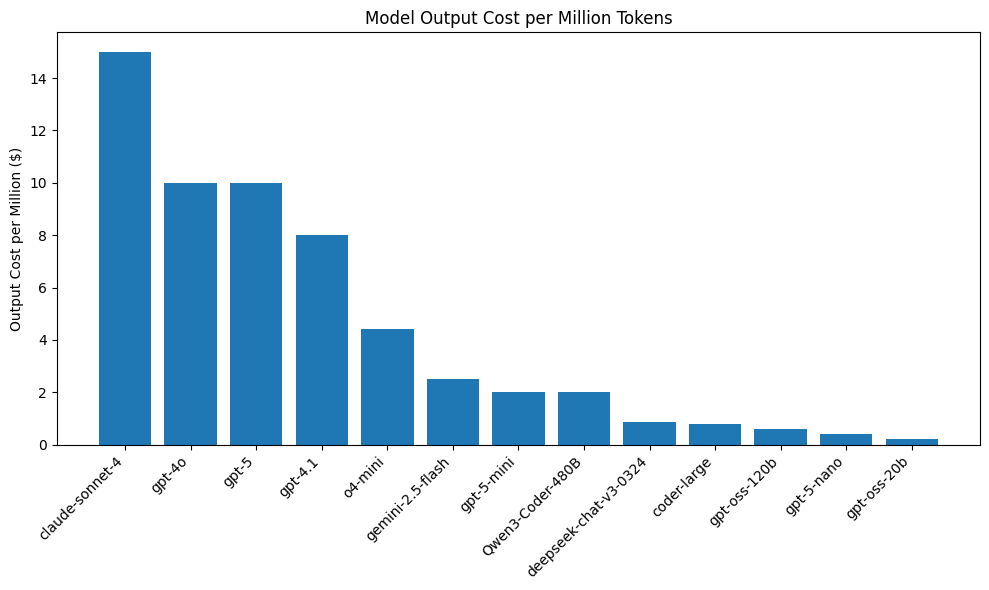

In [8]:
# Plot model costs
plt.figure(figsize=(10, 6))
plt.bar(model_info_sorted['model_name'], model_info_sorted['output_cost_per_million'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Output Cost per Million ($)')
plt.title('Model Output Cost per Million Tokens')
plt.tight_layout()
plt.show()

## Success and Attempts

Below is a complex grid plot that attempts to summarize this.

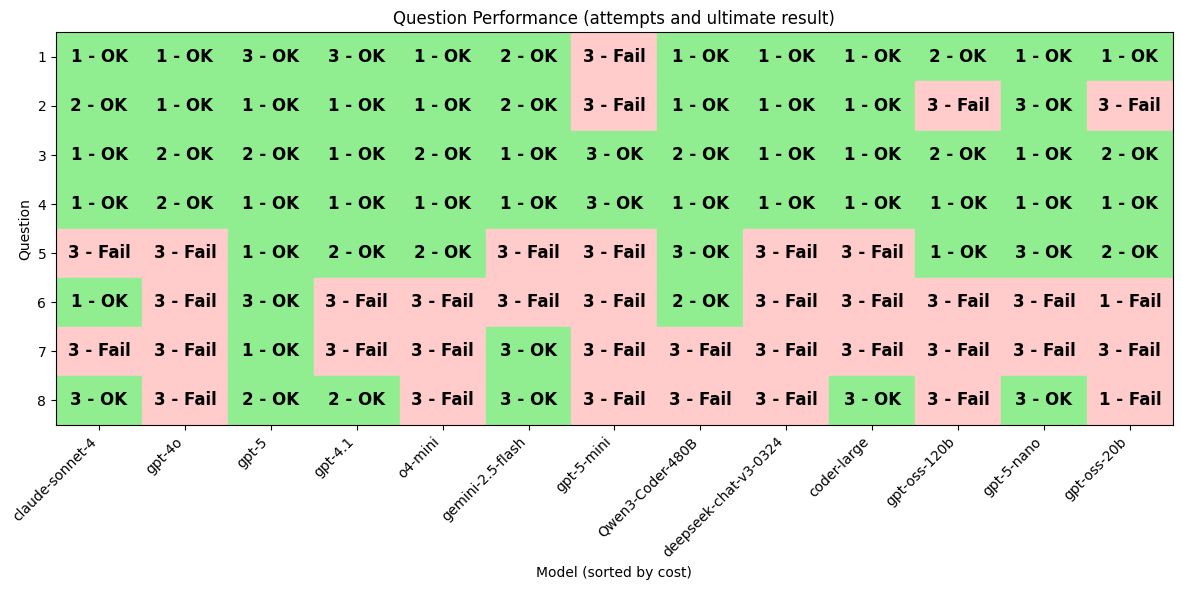

In [9]:
import numpy as np

# Prepare pivot table for grid, with columns sorted by model cost
sorted_nicknames = model_info_sorted['model_name'].tolist()
pivot = data.pivot(index='question', columns='model_nickname', values='Result')
pivot = pivot.reindex(columns=sorted_nicknames)

# Prepare attempts table for text labels
attempts_pivot = data.pivot(index='question', columns='model_nickname', values='Attempts')
attempts_pivot = attempts_pivot.reindex(columns=sorted_nicknames)

# Map results to colors
color_map = pivot.map(lambda x: '#90ee90' if x == 'Success' else '#ffcccb')  # light green/red

fig, ax = plt.subplots(figsize=(12, 6))

for (i, question) in enumerate(pivot.index):
    for (j, model) in enumerate(pivot.columns):
        color = color_map.loc[question, model]
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Show number of attempts as text label
        attempts = attempts_pivot.loc[question, model]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{attempts} - {'OK' if pivot.loc[question, model] == 'Success' else 'Fail'}",
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold",
        )

ax.set_xticks(np.arange(len(pivot.columns)) + 0.5)
ax.set_xticklabels(pivot.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(len(pivot.index)) + 0.5)
ax.set_yticklabels(pivot.index)
ax.set_xlim(0, len(pivot.columns))
ax.set_ylim(0, len(pivot.index))
ax.invert_yaxis()
ax.set_xlabel('Model (sorted by cost)')
ax.set_ylabel('Question')
ax.set_title('Question Performance (attempts and ultimate result)')
plt.tight_layout()
plt.show()

Some observations:

- There is a definite break between questions 4 and 5, and 5 and 6.
- Note that `gtp-oss-20b` sometimes fails with 1 attempt. That is because the model returns no code with the prompt.
- On average, performance is flash-ish across costs, which I find amazing, except for `gpt-5`.

## Questions 4, 5, and 6

Repeating questions 4, 5, and 6 here for reference:

4. Plot the ETmiss of events that have at least two jets with pT > 40 GeV in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697.
5. Plot the ETmiss of events that have an opposite-charge muon pair with an invariant mass between 60 and 120 GeV in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.513109.MGPy8EG_Zmumu_FxFx3jHT2bias_SW_CFilterBVeto.deriv.DAOD_PHYSLITE.e8514_e8528_s4162_s4114_r14622_r14663_p6697.
6. For events with at least three jets, plot the pT of the trijet four-momentum that has the invariant mass closest to 172.5 GeV in each event and plot the maximum b-tagging discriminant value among the jets in this trijet in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad.deriv.DAOD_PHYSLITE.e8514_s4369_r16083_p6697.

- Question 4 is a 2 objet (ETmiss and jets) question. The aggregation is just counting, which is then cut on.
- Question 5 is a 2 object (ETMiss and muons) question. The filtering is 2-object (opposite sign). The aggregation is the invariant mass calculation, which is then cut on.
- Question 6 is a 1 object (jets) question. But two plots. The b-tagging discriminate value in ATLAS requires a fair amount of extra code. Aggregation is 3-jet combinatorics, and then you have to pick the best b-tagging discriminate from that.

These questions certainly are increasingly more difficult.

## Hallucinations

While I did cursory inspections of the models output, the above plot makes it clear there might be some more careful investigation required. In particular, `coder-large` and `gtp-5-nano` both seem to have successes on question 8, which is very rare! In general, it seems that the change from question 4, to 5, and to 6 causes trouble.

The below table is one that lists cases where the models made the plots, but the plots are incorrect. The code is:

* **"H"** Straight up hallucination
* **"K"** Made some comment in `stdout` or `stderr` which indicated it knew something was wrong and needed a human to peer over its shoulder.

In [10]:
human_review = [
    ("5", "gpt-oss-20b", "H"), # Does not look at muons at all
    ("6", "Qwen3-Coder-480B-A35B-Instruct-FP8", "K"), # Knowns it can't get the correlation data
    ("7", "gemini-2.5-flash", "H"), # fails to look at events with no light leptons
    ("8", "claude-sonnet-4", "H"), # Plotted the invariant mass, not the transverse mass.
]

Adding this information to the table so we can make another "nice" grid plot.

In [11]:
# Add hallucination and corrected result columns
hallucination_map = {(int(q), m): h for q, m, h in human_review}
data['hallucination'] = data.apply(lambda row: hallucination_map.get((row['question'], row['model_nickname']), ''), axis=1)
def correct_result(row):
    if row['hallucination'] in ['H', 'K'] and row['Result'] == 'Success':
        return 'Fail'
    return row['Result']
data['Result_with_hallucination'] = data.apply(correct_result, axis=1)

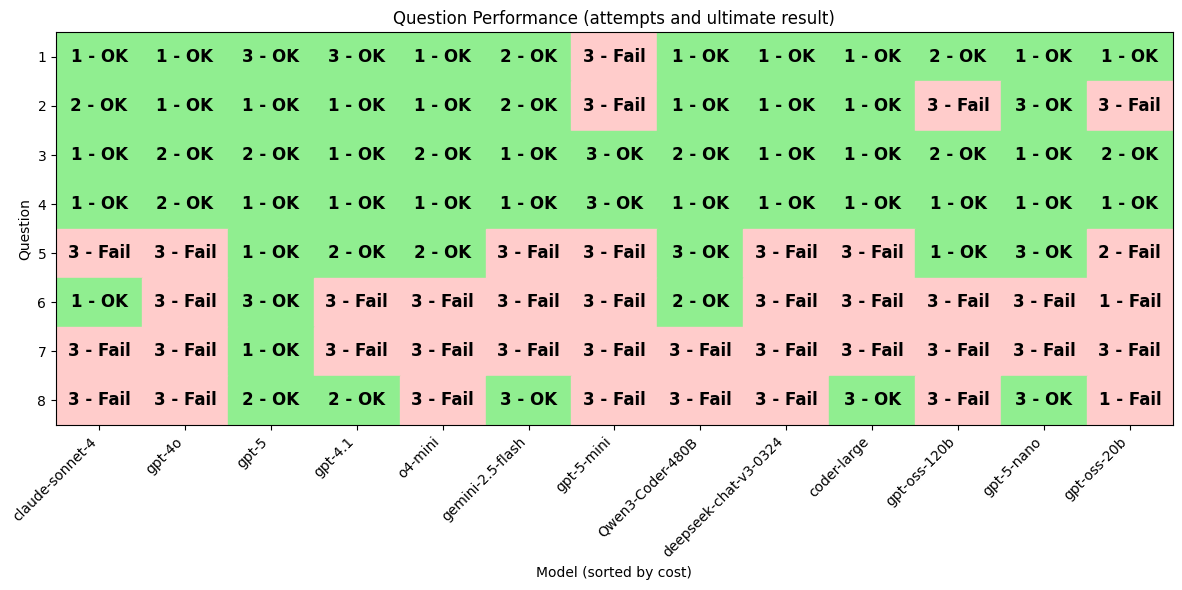

In [12]:
import numpy as np

# Prepare pivot table for grid, with columns sorted by model cost
sorted_nicknames = model_info_sorted["model_name"].tolist()
pivot = data.pivot(
    index="question", columns="model_nickname", values="Result_with_hallucination"
)
pivot = pivot.reindex(columns=sorted_nicknames)

# Prepare attempts table for text labels
attempts_pivot = data.pivot(
    index="question", columns="model_nickname", values="Attempts"
)
attempts_pivot = attempts_pivot.reindex(columns=sorted_nicknames)

# Map results to colors
color_map = pivot.map(
    lambda x: "#90ee90" if x == "Success" else "#ffcccb"
)  # light green/red

fig, ax = plt.subplots(figsize=(12, 6))

for i, question in enumerate(pivot.index):
    for j, model in enumerate(pivot.columns):
        color = color_map.loc[question, model]
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Show number of attempts as text label
        attempts = attempts_pivot.loc[question, model]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{attempts} - {'OK' if pivot.loc[question, model] == 'Success' else 'Fail'}",
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold",
        )

ax.set_xticks(np.arange(len(pivot.columns)) + 0.5)
ax.set_xticklabels(pivot.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(pivot.index)) + 0.5)
ax.set_yticklabels(pivot.index)
ax.set_xlim(0, len(pivot.columns))
ax.set_ylim(0, len(pivot.index))
ax.invert_yaxis()
ax.set_xlabel("Model (sorted by cost)")
ax.set_ylabel("Question")
ax.set_title("Question Performance (attempts and ultimate result)")
plt.tight_layout()
plt.show()